# Homework 1: Greenhouse Gases and Climate change

#### Deadline: Monday 14 October 2024 (by 5pm)

#### Credits: 20 points

## Name: 

- When you finish, please send me the **.ipynb** file via email to wbanda@yachaytech.edu.ec



- This homework is individual. Please include your name in the notebook.



- Within a **single python notebook**, solve the following problems:

## Problem 1. (9 points) Data I/O and regression: $\rm CO_2$ emission

This problem consists of reading, displaying, analysing, and modelling $\rm CO_2$ concentration data from a monitoring station located in Kennaook/Cape Grim, Australia.

The data files for this and the next exercises were downloaded from the CSIRO site:

https://www.csiro.au/en/research/natural-environment/atmosphere/Latest-greenhouse-gas-data

For this problem, you will use the following CSV file:

https://github.com/wbandabarragan/physics-teaching-data/blob/main/1D-data/CapeGrim_CO2_data_download.csv


### Tasks:

In [3]:
# Here import the necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import scipy.interpolate as interp
import scienceplots

In [4]:
# Set plot style
plt.style.use(['science', 'notebook', 'no-latex'])

(a) Inspect the structure of the file. Then, create a python function that uses **pandas** to read in the **CapeGrim_CO2_data_download.csv** file, skips the header, place the data into a pandas dataframe, and returns 3 columns as arrays, namely: "DATE", "CO2(ppm)", "SD(ppm)". The first one has the data collection times, the second one contains $\rm CO_2$ concentrations in $\rm ppm$, and the third one has the respective instrumental standard deviations also in $\rm ppm$.

In [6]:
# Let's read the file and print the contents
filename = './CapeGrim_CO2_data_download.csv'

# Read the data
data = pd.read_csv(filename, sep=',', skiprows = 24) # Use skiprows to skip the header

# Print the contents of the file
print(data)

     YYYY  MM  DD        DATE  CO2(ppm)  SD(ppm)  GR(ppm/yr)   Source
0    1976   5  15  1976.36890   328.861    0.165         NaN  in situ
1    1976   6  15  1976.45360   328.988    0.285         NaN  in situ
2    1976   7  15  1976.53550   329.653    0.282         NaN  in situ
3    1976   8  15  1976.62020   330.550    0.201         NaN  in situ
4    1976   9  15  1976.70490   330.872    0.234         NaN  in situ
..    ...  ..  ..         ...       ...      ...         ...      ...
575  2024   4  15  2024.28689   419.037    0.219         NaN  in situ
576  2024   5  15  2024.36885   419.501    0.215         NaN  in situ
577  2024   6  15  2024.45355   420.040    0.216         NaN  in situ
578  2024   7  15  2024.53552   420.472    0.146         NaN  in situ
579  2024   8  15  2024.62022   420.816    0.152         NaN  in situ

[580 rows x 8 columns]


In [8]:
# Having explored the structure of the data, we can now write 
# a function to read the desired columns and return the data as
# a numpy array

def ReadGreenHouseGasData(filename):
    """ 
    This function reads the C02 concentration data file. 
    It is a general function that can be used to read any file with the same structure.

    Arguments:
            - filename (str) : path/name of the file to read

    Returns:
            - time (np.array) : time data
            - co2 (np.array) : co2 concentration data
            - co2_err (np.array) : co2 concentration error data
    """
    # Read the data
    df = pd.read_csv(filename, sep=',', skiprows = 24)

    # Extract the columns of interest
    time = np.array(df.iloc[:,3])
    co2 = np.array(df.iloc[:,4])
    co2_err = np.array(df.iloc[:,5])

    return time, co2, co2_err

In [9]:
# Now we can call the function to read the data
time, co2, co2_err = ReadGreenHouseGasData(filename)

#print(time)
#print(co2) 
#print(co2_err)


(b) Now, you will rescale the uncertainties to more realistic values by multiplying the instrumental standard deviation by $10$, so $\sigma=10\,\sigma_{\rm instrumental}$. The instrumental uncertainties are very small, and there are unaccounted-for errors, such as systematic errors. A factor of $\sim 10$ is a fine estimate for this data set.

In [10]:
# Rescale the SD of the data
co2_err_rescaled = 10 * co2_err

(c) Make a high-quality, labeled plot of the $\rm CO_2$ concentrations (in $\rm ppm$) versus time, including the y-error bars equal to the uncertainties calculated in (b).

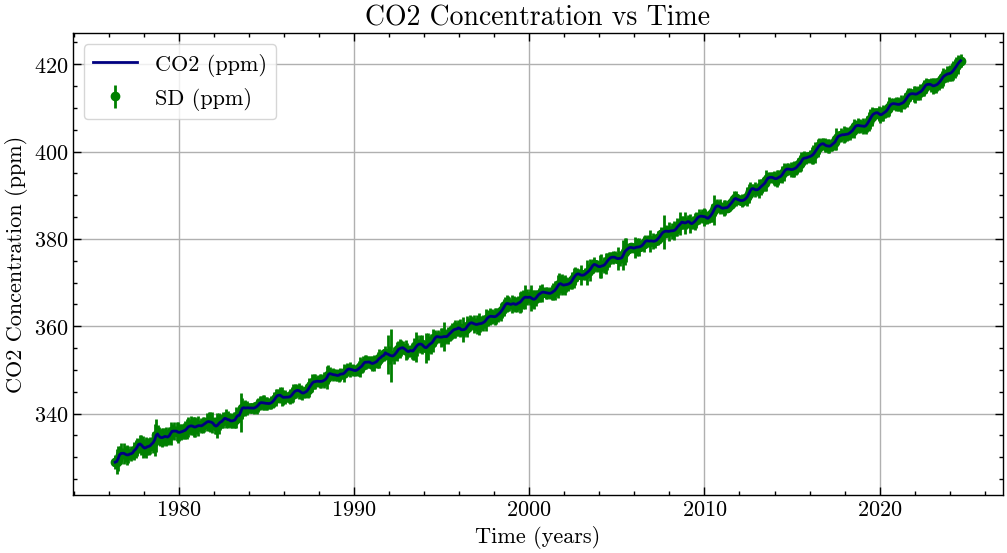

In [24]:
fig, ax = plt.subplots(figsize = (12, 6))

ax.plot(time, co2, color = 'navy', linestyle = '-', label = 'CO2 (ppm)', zorder = 3)
ax.errorbar(time, co2, yerr = co2_err_rescaled, fmt = 'o', color = 'g', label = 'SD (ppm)')

# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = 'CO2 Concentration (ppm)')
ax.set_title('CO2 Concentration vs Time', fontsize = 20)
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

(d) How monotonic and linear is the relation between the two variables?

In [14]:
# Let's calculate these coefficients to determine linearity and monotonicity in the data
# 1. Spearman coefficient
sp = st.spearmanr(time, co2)

# 2. Pearson coefficient
pe = st.pearsonr(time, co2)

print("Spearman:\n", sp)
print("Pearson:\n", float(pe[0])**2)

Spearman:
 SignificanceResult(statistic=0.99979570134535, pvalue=0.0)
Pearson:
 0.990526771654504


The Spearman coefficient calculated above indicates a very strong monotonic relationship between time and $\rm CO_2$ concentration. Additionally, the Pearsom coefficient indicates a strong linear relationship between the two variables.

(e) Now, you will carry out a regression on the data, assuming a simple linear regression model (**"Model 1"**) with 2 free parameters. Carry out a $\chi^2$ minimisation, and report the resulting equation and figure. The figure should have a high-quality, labeled plot of the original data with error bars and the resulting best-fit line.

In [17]:
# Define the linear model for the chi-square minimisation

def LinearModel1(t, m, b):
    """ 
    This function defines a linear model for the chi-square minimisation

    Arguments:
            - t (np.array) : time data
            - m (float) : slope
            - b (float) : intercept

    Returns:
            - np.array : linear model
    """
    return m * t + b

In [19]:
# Define a functional/chi^2 statistic
def ChiSqrModel1(params):
    """
    This function defines a chi-square statistic for the linear model 1.

    Arguments:
            - params (np.array) : parameters of the model

    Returns:
            - float : chi-square value 
    """
    # Extract the parameters
    m, b = params
    # Use the chi^2 formula
    chi_sqr = np.sum((co2 - LinearModel1(time, m, b))**2 / (co2_err_rescaled)**2)
    
    return chi_sqr

In [20]:
# Perform the minimisation
# Ansatsz (educated guess)
coef_1 = np.array([1.5, -3000])

# Call the minimisation routine
opt_model_1 = opt.minimize(ChiSqrModel1, coef_1)

# print the result
#print(opt_model_1)

# Extract the optimized parameters
m_opt, b_opt = opt_model_1.x

# Print the results
print("########## OPTIMAL PARAMETERS ###########")
print(f"Optimized m: {m_opt}")
print(f"Optimized b: {b_opt}")
print("########## UNCERTAINTIES ###########")
print(f"Uncertainty in m: {np.sqrt(opt_model_1.hess_inv[0,0])}")
print(f"Uncertainty in b: {np.sqrt(opt_model_1.hess_inv[1,1])}")

########## OPTIMAL PARAMETERS ###########
Optimized m: 1.7532228895344044
Optimized b: -3137.2795312570006
########## UNCERTAINTIES ###########
Uncertainty in m: 0.002525358661824294
Uncertainty in b: 5.047025827704763


The equation of the linear model is given by:

$$ 
\rm CO_2(t) = 1.7532231072632332 * t -3137.2799664027966
$$

where $t$ is the time in years.

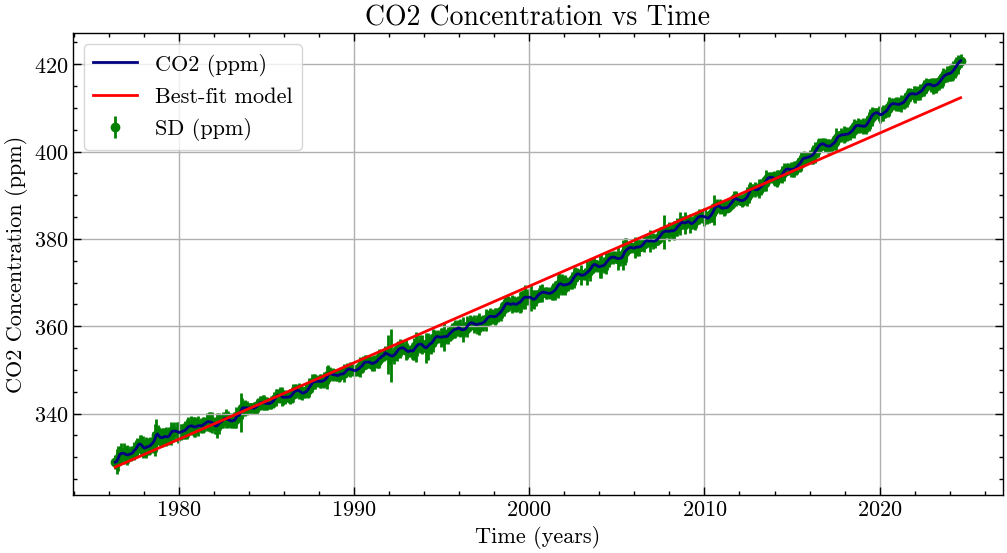

In [25]:
# Plot the fitter model
fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(time, co2, yerr = co2_err_rescaled, fmt = 'o', color = 'green', label = 'SD (ppm)', zorder = 1)
ax.plot(time, co2, color = 'navy', linestyle = '-', label = 'CO2 (ppm)')
ax.plot(time, LinearModel1(time, m_opt, b_opt), color = 'red', linestyle = '-', label = 'Best-fit model')
ax.set(xlabel = 'Time (years)', ylabel = 'CO2 Concentration (ppm)')
ax.set_title('CO2 Concentration vs Time', fontsize = 20)
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

(f) To perform a goodness-of-fit test, create a python function that calculates the global $\chi^2$ statistic, the number of degrees of freedom, and the reduced $\chi^2$ statistic. Briefly comment on your findings, is the linear model a good model?

In [26]:
def GoodnessFitModel1(co2, params):
    """ 
    Function to calculate the goodness of fit for the linear model.

    Arguments:
            - co2 (np.array) : co2 data
            - params (np.array) : parameters of the model

    Returns:
            - chi_squared (float) : chi-squared statistic
            - nu (int) : degrees of freedom
            - reduced_chi_squared (float) : reduced chi-squared statistic
    """
    
    # Calculate the Chi-squared statistic
    chi_squared = ChiSqrModel1(params)
    
    # Calculate the number of degrees of freedom
    nu = len(co2) - len(params)
    
    # Calculate the reduced Chi-squared statistic
    reduced_chi_squared = chi_squared / nu
    
    return chi_squared, nu, reduced_chi_squared

In [27]:
# Call the goodness of fit function
chi_squared_1, nu_1, reduced_chi_squared_1 = GoodnessFitModel1(co2, opt_model_1.x)

print("Chi-squared: ", chi_squared_1)
print("Degrees of freedom: ", nu_1)
print("Reduced Chi-squared: ", reduced_chi_squared_1)

Chi-squared:  2359.3167656871733
Degrees of freedom:  578
Reduced Chi-squared:  4.081862916413795


Taking into account the values of the $\chi^2_{\text{red}}$, which is $\sim 4.08186$, we can conclude that the linear model is not a good model for the data. Even though the Pearson coefficient indicates a strong linear relationship between the two variables, the $\chi^2_{\text{red}}$ value is too high, which indicates that a linear model may not be the best model to describe the data.

(g) Next, you can propose your own model (**"Model 2"**) for the data. Motivate and write down your model. Then, repeat steps (e) and (f) for your model and compare the reduced $\chi^2$ statistic with that of the linear model. Which model is better? Hint: Keep the model simple with maximum 2 free parameters and avoid overfitting.

If we have a closer look at the data, we can see that the $\rm CO_2$ concentration is not linearly increasing with time. The data seems to have a exponential-like behaviour. Therefore, we propose a exponential model for the data. The equation of the exponential model is given by:

$$
\rm CO_2(t) = a * \exp{(b*t)}
$$

where $t$ is the time in years, and $a$ and $c$ are the free parameters.



In [28]:
# Define the exponential model for the chi-square minimisation
def ExponentialModel1(t, a, c):
    """ 
    Function to model an exponential function for the chi-square minimisation.

    Arguments:
            - t (np.array) : time data
            - a (float) : amplitude
            - c (float) : exponential coefficient

    Returns:
            - np.array : exponential model
    """
    return a * np.exp(c * t)

In [33]:
# Define the chi^2 statistic function
def ChiSqrExpModel1(params):
    """
    Function to calculate the chi-square statistic for the exponential model 1. 

    Arguments:
            - params (np.array) : parameters of the model

    Returns:
            - chi_sqr (float) : chi-square statistic
    """
    # Extract the parameters
    a, c = params
    # Use the chi^2 formula
    chi_sqr = np.sum((co2 - ExponentialModel1(time, a, c))**2 /(co2_err_rescaled)**2)
    
    return chi_sqr

In [34]:
# Perform the minimisation

# Ansatsz (educated guess)
coef_2 = np.array([25, 0.0015])

# Call the minimisation routine
opt_model_2 = opt.minimize(ChiSqrExpModel1, coef_2)

# print the result
#print(opt_model_2)

# Extract the optimized parameters
a_opt, c_opt = opt_model_2.x

# Print the results
print("########## OPTIMAL PARAMETERS ###########")
print(f"Optimized a: {a_opt}")
print(f"Optimized c: {c_opt}")
print("########## UNCERTAINTIES ###########")
print(f"Uncertainty in a: {np.sqrt(opt_model_2.hess_inv[0,0])}")
print(f"Uncertainty in c: {np.sqrt(opt_model_2.hess_inv[1,1])}")

########## OPTIMAL PARAMETERS ###########
Optimized a: 0.03129388588707008
Optimized c: 0.004686601389203387
########## UNCERTAINTIES ###########
Uncertainty in a: 0.00043347258042872105
Uncertainty in c: 6.922436010532375e-06


The equation of the exponential model is given by:

$$ 
\rm CO_2(t) = 0.03129 * \exp{(0.00469*t)}
$$

where $t$ is the time in years.

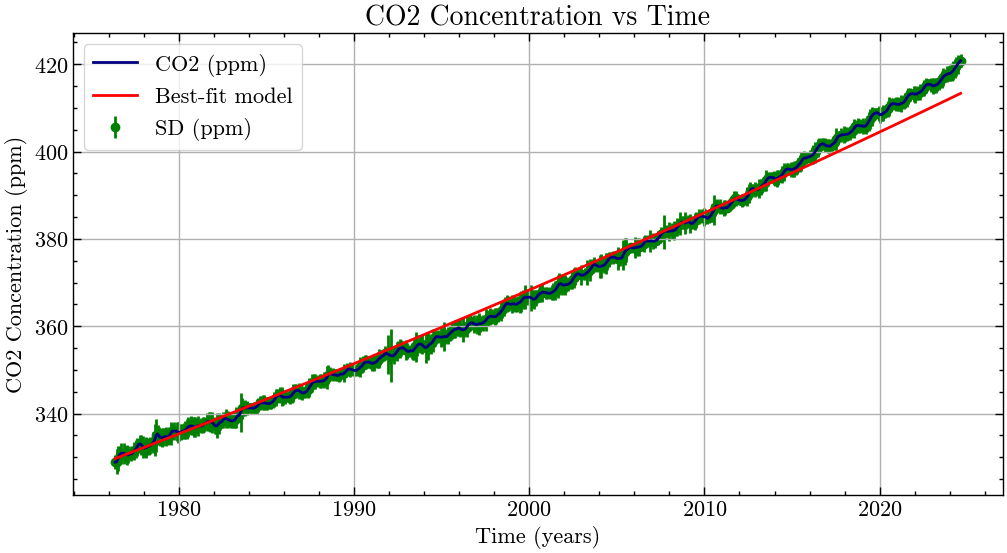

In [35]:
# Plot the fitter model
fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(time, co2, yerr = co2_err_rescaled, fmt = 'o', color = 'green', label = 'SD (ppm)', zorder = 1)
ax.plot(time, co2, color = 'navy', linestyle = '-', label = 'CO2 (ppm)')
ax.plot(time, ExponentialModel1(time, a_opt, c_opt), color = 'red', linestyle = '-', label = 'Best-fit model')
ax.set(xlabel = 'Time (years)', ylabel = 'CO2 Concentration (ppm)')
ax.set_title('CO2 Concentration vs Time', fontsize = 20)
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

In [36]:
def GoodnessFitExpModel1(co2, params):
    """ 
    Function to calculate the goodness of fit for the exponential model 1. 

    Arguments:
            - co2 (np.array) : co2 data
            - params (np.array) : parameters of the model

    Returns:
            - chi_squared (float) : chi-squared statistic
            - nu (int) : degrees of freedom
            - reduced_chi_squared (float) : reduced chi-squared statistic
    """
    # Calculate the Chi-squared statistic
    chi_squared = ChiSqrExpModel1(params)
    
    # Calculate the number of degrees of freedom
    nu = len(co2) - len(params)
    
    # Calculate the reduced Chi-squared statistic
    reduced_chi_squared = chi_squared / nu
    
    return chi_squared, nu, reduced_chi_squared

In [37]:
# Call the goodness of fit function
chi_squared_2, nu_2, reduced_chi_squared_2 = GoodnessFitExpModel1(co2, opt_model_2.x)

print("Chi-squared: ", chi_squared_2)
print("Degrees of freedom: ", nu_2)
print("Reduced Chi-squared: ", reduced_chi_squared_2)

Chi-squared:  1400.3040880315916
Degrees of freedom:  578
Reduced Chi-squared:  2.4226714325806085


Based on the goodness-of-fit test, the exponential model is a better model for the data. The $\chi^2_{\text{red}}$ value is $\sim 2.42$, which is significantly lower than the $\chi^2_{\text{red}}$ value of the linear model. This indicates that the exponential model is a better choice to describe the data.

(h) Finally, you will construct **2D confidence intervals** using the $\chi^2$ statistic evaluated in the vicinity of the best-fit values for the free parameters of Models 1 and 2. Since both models have two free parameters, you should create python functions that compute and return the 2D $\chi^2$ surface of each model onto the respective parameter space. Hints: to create a 2D parameter space as a meshgrid, you should first create vectors with numbers around the best-fit values found in your regressions. 1D plots showing $\chi^2$ as a function of each parameter may help identify optimal numbers.

In [38]:
# Let's create a vector for each parameter in both models
# We will use the uncertainties in the parameters to create these vectors
# Model 1
lm_m = np.linspace(m_opt - 5 * np.sqrt(opt_model_1.hess_inv[0,0]), m_opt + 5 * np.sqrt(opt_model_1.hess_inv[0,0]), 100)
lm_b = np.linspace(b_opt - 5 * np.sqrt(opt_model_1.hess_inv[1,1]), b_opt + 5 * np.sqrt(opt_model_1.hess_inv[1,1]), 100)


# Model 2
expm_a = np.linspace(a_opt - 5 * np.sqrt(opt_model_2.hess_inv[0,0]), a_opt + 5 * np.sqrt(opt_model_2.hess_inv[0,0]), 100)
expm_b = np.linspace(c_opt - 5 * np.sqrt(opt_model_2.hess_inv[1,1]), c_opt + 5 * np.sqrt(opt_model_2.hess_inv[1,1]), 100)

In [39]:
# Create a function to compute the 2D chi^2 grid

def ChiSqr2D(x_vec, y_vec, chi_sqr_func):
    """ 
    Function to compute the 2D surface of the chi^2 values.

    Arguments:
            - x_vec (np.array) : vector of x values
            - y_vec (np.array) : vector of y values
            - chi_sqr_func (function) : chi^2 function

    Returns:
            - X (np.array) : meshgrid x values
            - Y (np.array) : meshgrid y values
            - Z (np.array) : chi^2 values
    """
    # Create a meshgrid
    X, Y = np.meshgrid(x_vec, y_vec)
    
    # Create a 2D array to store the chi^2 values
    Z = np.zeros((len(x_vec), len(y_vec)))
    
    # Loop over the meshgrid and compute the chi^2 values
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            Z[i, j] = chi_sqr_func([x_vec[i], y_vec[j]])
            
    return X, Y, Z

In [40]:
# Call the function for both models
m_2d, b_2d, chi_2d_1 = ChiSqr2D(lm_m, lm_b, ChiSqrModel1)
a_2d, c_2d, chi_2d_2 = ChiSqr2D(expm_a, expm_b, ChiSqrExpModel1)

(i) Make a high-quality, labeled, multi-panel figure showing the 2D $\chi^2$ surface of each model: first in 3D, and then in projection with a marker showing the minimum and overimposed contours indicating at least two confidence levels. Briefly comment on your results highlighting the differences between the confidence intervals of both models. What do these confidence intervals tell us? Hint: the maps should have one of the free parameters in the X axis, the other free parameter in the Y axis, and the $\chi^2$ surface in the Z axis.

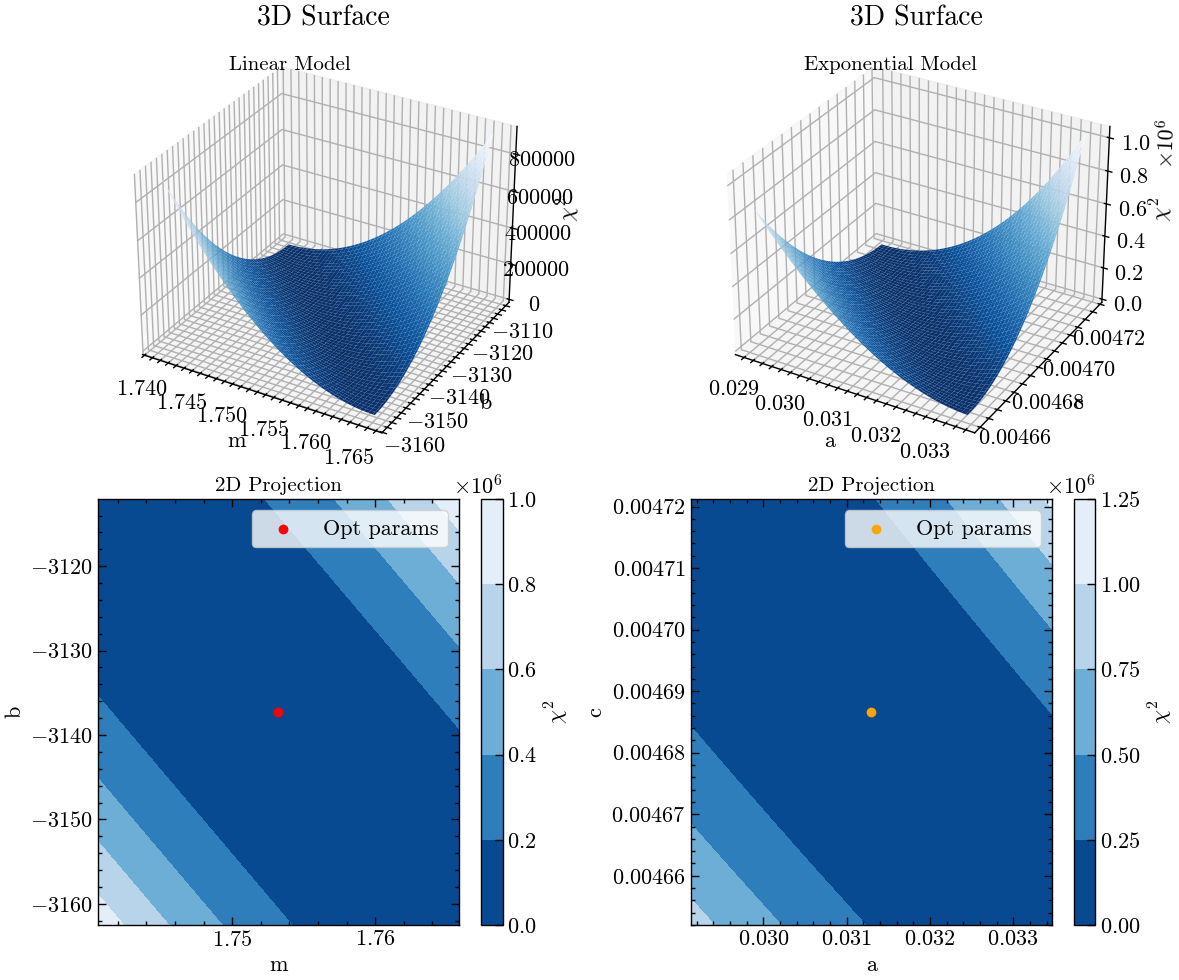

In [47]:
# Let's make a 4 panel plot to show the 2D chi^2 surfaces in 3D and 2D
fig = plt.figure(figsize = (12, 10))

# Model 1 3D
ax1 = fig.add_subplot(221, projection = '3d')
ax1.plot_surface(m_2d, b_2d, chi_2d_1, cmap = 'Blues_r')
ax1.set(xlabel = 'm', ylabel = 'b', zlabel = r'$\chi^2$')
ax1.set_title('3D Surface', fontsize = 20)

# Model 2 3D
ax2 = fig.add_subplot(222, projection = '3d')
ax2.plot_surface(a_2d, c_2d, chi_2d_2, cmap = 'Blues_r')
ax2.set(xlabel = 'a', ylabel = 'c', zlabel = r'$\chi^2$')
ax2.set_title('3D Surface', fontsize = 20)

# Model 1 2D
ax3 = fig.add_subplot(223)
ax3.contourf(m_2d, b_2d, chi_2d_1, cmap = 'Blues_r')
cbar_3 = plt.colorbar(ax3.contourf(m_2d, b_2d, chi_2d_1, levels = 4, cmap = 'Blues_r'))
cbar_3.set_label(r'$\chi^2$')
ax3.scatter(m_opt, b_opt, color = 'red', label = 'Opt params')
ax3.set(xlabel = 'm', ylabel = 'b')
ax3.set_title('2D Projection', fontsize = 15)

# Model 2 2D
ax4 = fig.add_subplot(224)
ax4.contourf(a_2d, c_2d, chi_2d_2, cmap = 'Blues_r')
cbar_4 = plt.colorbar(ax4.contourf(a_2d, c_2d, chi_2d_2, levels = 4, cmap = 'Blues_r'))
cbar_4.set_label(r'$\chi^2$')
ax4.scatter(a_opt, c_opt, color = 'orange', label = 'Opt params')
ax4.set(xlabel = 'a', ylabel = 'c')
ax4.set_title('2D Projection', fontsize = 15)


fig.text(0.25, 0.92, 'Linear Model', ha='center', fontsize=15)
fig.text(0.75, 0.92, 'Exponential Model', ha='center', fontsize=15)
ax3.legend(frameon = True)
ax4.legend(frameon = True)

plt.tight_layout()
plt.show()
plt.close()

We can see that both $\chi^2$ surfaces are locally identical to each other. Showing a parabolic-like shape and a minimum at the best-fit parameters of each model correspondingly. Regarding the confidence intervals, the Linear model has a larger confidence interval compared to the Exponential model. This indicates that the Linear model has a larger uncertainty in the parameters compared to the Exponential model. The confidence intervals tell us how well the parameters are constrained by the data. The smaller the confidence interval, the better the parameters are constrained by the data.
 
We must also mention that, although there seems to be a minimum in both $\chi^2$ surfaces, the minimum is not well defined. We would expect to see circular contours around the minimum, which would indicate a well-defined minimum. However, that is not the case here. We may need to increase the range of the parameters to see better behaviour of the $\chi^2$ surfaces.

## Problem 2. (5 points) Interpolation: Greenhouse Gases

In this problem, you will calculate and compare the amount of heating produced by three greenhouse gases:

- $\rm CO_2$, which you already analysed in the previous problem.

- $\rm CH_4$, whose data you can find here:
  https://github.com/wbandabarragan/physics-teaching-data/blob/main/1D-data/CapeGrim_CH4_data_download.csv

- $\rm N_2O$, whose data you can find here:
  https://github.com/wbandabarragan/physics-teaching-data/blob/main/1D-data/CapeGrim_N2O_data_download.csv

All the data were taken by the same monitoring station in Australia. The new files for $\rm CH_4$ and $\rm N_2O$ have the same structure as the file for $\rm CO_2$, but the concentrations and standard deviations are in units of $\rm ppb$.

### Tasks:

(a) Repeat steps (a), (b) and (c) of problem 1 for $\rm CH_4$ and $\rm N_2O$. Which of the 3 greenhouse gases has higher and lower concentrations in the atmosphere? How many $\rm dex$ apart are their concentrations? 

In [48]:
# Let's set the filename for the other greenhouse gases
filename_ch4 = './CapeGrim_CH4_data_download.csv'
filename_n2o = './CapeGrim_N2O_data_download.csv'

In [49]:
# Check the structure of the data
data_ch4 = pd.read_csv(filename_ch4, sep = ',', skiprows = 24)
data_n2o = pd.read_csv(filename_n2o, sep = ',', skiprows = 24)

#print(data_ch4)
# The data is structured in the same way as the CO2 data, so we can use the same function to read the data

In [50]:
# Read the data for CH4
time_ch4, ch4, ch4_err = ReadGreenHouseGasData(filename_ch4)

# Read the data for N2O
time_n2o, n2o, n2o_err = ReadGreenHouseGasData(filename_n2o)

# Convert ppb to ppm for CH4 and N2O (including the errors)
ch4_ppm = ch4 / 1000
ch4_err_ppm = ch4_err / 1000
n2o_ppm = n2o / 1000
n2o_err_ppm = n2o_err / 1000


# Rescale the SD of the data for CH4 and N2O
ch4_err_rescaled = 10 * ch4_err_ppm
n2o_err_rescaled = 10 * n2o_err_ppm

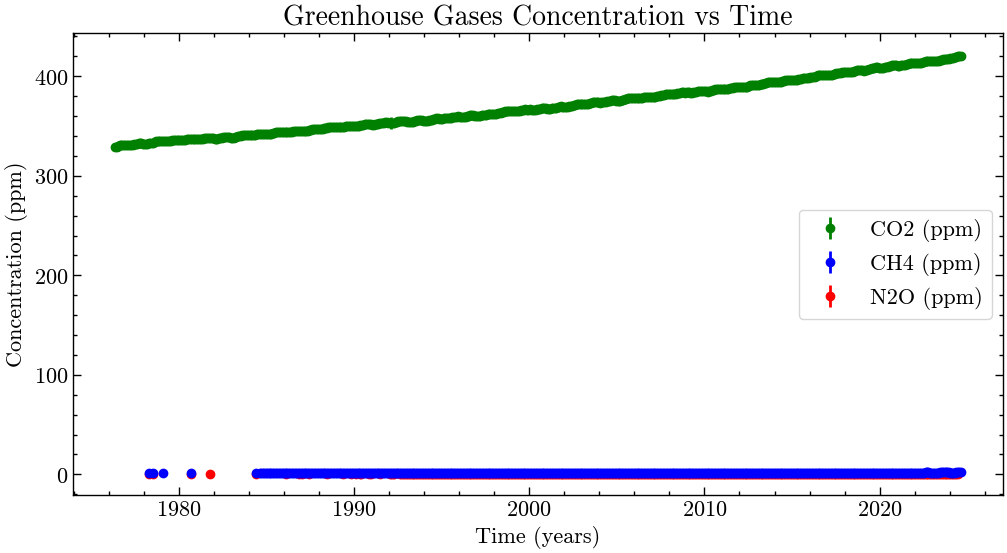

In [51]:
# Let's plot the data of the three greenhouse gases
fig, ax = plt.subplots(figsize = (12, 6))

ax.errorbar(time, co2, yerr = co2_err_rescaled, fmt = 'o', color = 'green', label = 'CO2 (ppm)', zorder = 3)
ax.errorbar(time_ch4, ch4_ppm, yerr = ch4_err_rescaled, fmt = 'o', color = 'blue', label = 'CH4 (ppm)', zorder = 2)
ax.errorbar(time_n2o, n2o_ppm, yerr = n2o_err_rescaled, fmt = 'o', color = 'red', label = 'N2O (ppm)', zorder = 1)

# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = 'Concentration (ppm)')
ax.set_title('Greenhouse Gases Concentration vs Time', fontsize = 20)
plt.legend(frameon = True)
plt.show()
plt.close()

We can see that $CO_2$ has the highest concentration in the atmosphere, followed by $CH_4$, and $N_2O$ has the lowest concentration.
To see how many $\rm dex$ apart the concentrations are, we can calculate the difference in the concentrations in $\rm dex$:

$$
\rm dex = \log_{10}(\frac{[Gas1]}{[Gas2]})
$$

To compute the $\rm dex$ difference between the concentrations of $CO_2$, $CH_4$ and $N_2O$, we can compute the mean concetration of each gas and then calculate the $\rm dex$ difference.


In [52]:
# Let's calculate the average concentration of each greenhouse gas
avg_co2_concentration = np.mean(co2)
avg_ch4_concentration = np.mean(ch4_ppm)
avg_n2o_concentration = np.mean(n2o_ppm)

# compute the dex difference between the different greenhouse gases
co2_ch4_dex_diff = np.log10(avg_co2_concentration / avg_ch4_concentration)
co2_n2o_dex_diff = np.log10(avg_co2_concentration / avg_n2o_concentration)
n2o_ch4_dex_diff = np.log10(avg_ch4_concentration / avg_n2o_concentration)

# Print the results
print("dex difference between CO2 and CH4: ", co2_ch4_dex_diff)
print("dex difference between CO2 and N2O: ", co2_n2o_dex_diff)
print("dex difference between CH4 and N2O: ", n2o_ch4_dex_diff)

dex difference between CO2 and CH4:  2.329340625176059
dex difference between CO2 and N2O:  3.06217155374532
dex difference between CH4 and N2O:  0.732830928569261



(b) Now, you will compute the amount of heat (energy) trapped by the greenhouse gases in the atmosphere by computing the so-called **radiative forcing** ($\Delta F$), which refers to the change in energy balance in the atmosphere due to greenhouse gas concentrations. For each gas the semi-empirical functions read:

- For $\rm CO_2$: $\Delta F_{\text{CO}_2} = \alpha \cdot \ln\left(\frac{C}{C_0}\right)$, where: $\Delta F_{\text{CO}_2}$ is the radiative forcing due to carbon dioxide ($\rm W/m^2$), $\alpha = 5.35 \, \rm W/m^2$, $C$ is the ctime-dependent concentration of $\text{CO}_2 $ in $\rm ppm$, and $C_0$ is the pre-industrial concentration of $\text{CO}_2$ in $\rm ppm$ (typically $=280$).

- For $\text{CH}_4$: $\Delta F_{\text{CH}_4} = \beta \cdot \left(\sqrt{M} - \sqrt{M_0}\right)$, where: $\Delta F_{\text{CH}_4}$ is the radiative forcing due to methane ($\rm W/m^2$), $\beta = 0.036 \, \rm W/m^2 $, $M$ is the time-dependent concentration of $\rm CH_4$ in ppb, and $M_0$ is the pre-industrial concentration of $\text{CH}_4$ in $\rm ppb$ (typically $=700$).

- For $\rm N_2O$: $\Delta F_{\text{N}_2\text{O}} = \gamma \cdot \left(\sqrt{N} - \sqrt{N_0}\right)$, where: $\Delta F_{\text{N}_2\text{O}} $ is the radiative forcing due to nitrous oxide ($\rm W/m^2$), $\gamma = 0.12 \, \rm W/m^2$, $N$ is the time-dependent concentration of $\rm N_2O$ in ppb, $N_0$ is the pre-industrial concentration of $\text{N}_2\text{O}$ in $\rm ppb$ (typically $=270$).

The full expressions can be found in this paper (see table 1): https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL071930

In [53]:
# Define the constants for each semi-empirical model
alpha = 5.35  # W/m^2 for CO2
beta = 0.036  # W/m^2 for CH4
gamma = 0.12  # W/m^2 for N2O
C0 = 280  # ppm for pre-industrial CO2
M0 = 700  # ppb for pre-industrial CH4
N0 = 270  # ppb for pre-industrial N2O

In [54]:
# Radiative forcing for CO2
delta_F_CO2 = alpha * np.log(co2 / C0)
# Radiative forcing for CH4
delta_F_CH4 = beta * (np.sqrt(ch4) - np.sqrt(M0))
# Radiative forcing for N2O
delta_F_N2O = gamma * (np.sqrt(n2o) - np.sqrt(N0))

# Compute the erros for the radiative forcing
delta_F_CO2_err = alpha * np.log(co2_err_rescaled / C0)
delta_F_CH4_err = beta * (0.5 * ch4_err_rescaled / np.sqrt(ch4))

Now, let's compute the uncertainties in the radiative forcings. The general formula for the uncertainty in a function of several variables is given by:

$$
\sigma_{\Delta F} = \sqrt{\left(\frac{\partial \Delta F}{\partial x}\right)^2 \sigma_x^2 + \left(\frac{\partial \Delta F}{\partial y}\right)^2 \sigma_y^2 + \left(\frac{\partial \Delta F}{\partial z}\right)^2 \sigma_z^2}
$$

where $x$, $y$, and $z$ are the variables, and $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the uncertainties in $x$, $y$, and $z$, respectively.

So, the uncertainties in the radiative forcings of $\rm CO_2$, $\rm CH_4$, and $\rm N_2O$ are:

$$
\sigma_{\Delta F_{\text{CO}_2}} = \sqrt{\left(\frac{\partial \Delta F_{\text{CO}_2}}{\partial C}\right)^2 \sigma_C^2}
$$

$$
\sigma_{\Delta F_{\text{CH}_4}} = \sqrt{\left(\frac{\partial \Delta F_{\text{CH}_4}}{\partial M}\right)^2 \sigma_M^2}
$$

$$
\sigma_{\Delta F_{\text{N}_2\text{O}}} = \sqrt{\left(\frac{\partial \Delta F_{\text{N}_2\text{O}}}{\partial N}\right)^2 \sigma_N^2}
$$

where $\sigma_C$, $\sigma_M$, and $\sigma_N$ are the uncertainties in the concentrations of $\rm CO_2$, $\rm CH_4$, and $\rm N_2O$, respectively.

Computing the derivatives, we find:

$$
\sigma_{\Delta F_{\text{CO}_2}} = \frac{\alpha}{C} \sigma_C
$$

$$
\sigma_{\Delta F_{\text{CH}_4}} = \frac{\beta}{2\sqrt{M}} \sigma_M
$$

$$
\sigma_{\Delta F_{\text{N}_2\text{O}}} = \frac{\gamma}{2\sqrt{N}} \sigma_N
$$


In [55]:
# define a function to compute the uncertainties in the radiative forcing

def DeltaForceUncertainty(co2, co2_err, ch4, ch4_err, n2o, n2o_err):
    """
    Function to compute the uncertainties in the radiative forcing.

    Arguments:
            - co2 (np.array)     : co2 data
            - co2_err (np.array) : co2 error data
            - ch4 (np.array)     : ch4 data
            - ch4_err (np.array) : ch4 error data
            - n2o (np.array)     : n2o data
            - n2o_err (np.array) : n2o error data

    Returns:
            - delta_F_CO2_err (np.array) : uncertainty in the radiative forcing for CO2
            - delta_F_CH4_err (np.array) : uncertainty in the radiative forcing for CH4
            - delta_F_N2O_err (np.array) : uncertainty in the radiative forcing for
    """

    # Compute the erros for the radiative forcing
    delta_F_CO2_err = abs((alpha / co2) * co2_err)
    delta_F_CH4_err = abs((beta / (2 * np.sqrt(ch4))) * ch4_err)
    delta_F_N2O_err = abs((gamma / (2 * np.sqrt(n2o))) * n2o_err)

    return delta_F_CO2_err, delta_F_CH4_err, delta_F_N2O_err

In [56]:
# Call the function
delta_F_CO2_err, delta_F_CH4_err, delta_F_N2O_err = DeltaForceUncertainty(co2, co2_err_rescaled, ch4_ppm, ch4_err, n2o_ppm, n2o_err)

(c) Make a single high-quality, labeled plot showing the **radiative forcings** ($\Delta F$) of all three greenhouse gases in units of $\rm W/m^2 $ (including the y-error bars) versus time. How many $\rm dex$ apart are their contributions? Compare with your dex analysis in point (a) and discuss which gas has a higher warming potential.

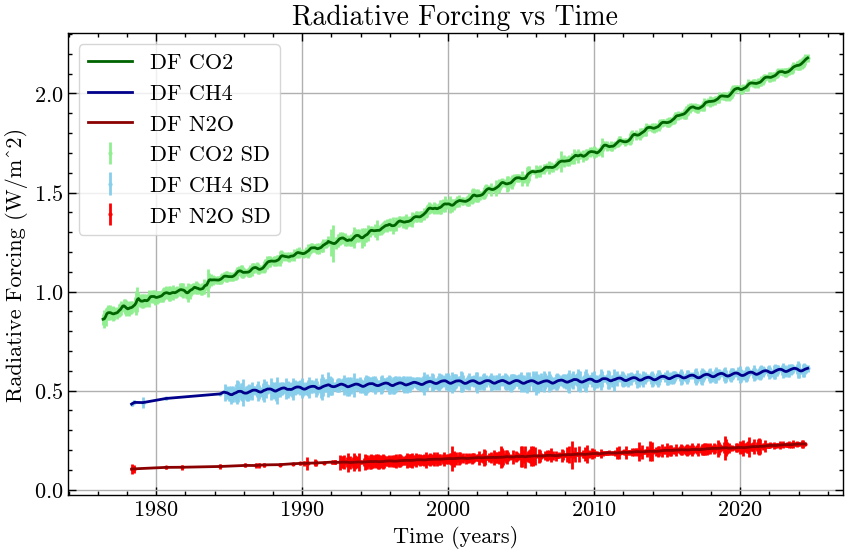

In [65]:
# Let's plot the radiative forcing for the three greenhouse gases
fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(time, delta_F_CO2, color = 'darkgreen', label = 'DF CO2', zorder = 3)
ax.plot(time_ch4, delta_F_CH4, color = 'darkblue', label = 'DF CH4', zorder = 3)
ax.plot(time_n2o, delta_F_N2O, color = 'darkred', label = 'DF N2O', zorder = 3)

# Plot the errors
ax.errorbar(time, delta_F_CO2, yerr = delta_F_CO2_err, fmt = 'o', color = 'lightgreen', markersize = 2, label = 'DF CO2 SD')
ax.errorbar(time_ch4, delta_F_CH4, yerr = delta_F_CH4_err, fmt = 'o', color = 'skyblue', markersize = 2, label = 'DF CH4 SD')
ax.errorbar(time_n2o, delta_F_N2O, yerr = delta_F_N2O_err, fmt = 'o', color = 'red', markersize = 2, label = 'DF N2O SD')


# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = 'Radiative Forcing (W/m^2)')
ax.set_title('Radiative Forcing vs Time', fontsize = 20)
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

To see how many $\rm dex$ apart the contributions are, we can calculate the difference in the contributions in $\rm dex$:

$$
\rm dex = \log_{10}(\frac{\Delta F_{Gas 1}}{\Delta F_{Gas 2}})
$$

Similarly to the concentrations, we can compute the mean contribution of each gas and then calculate the $\rm dex$ difference between the contributions.

In [58]:
# Compute the average radiative forcing for each greenhouse gas
avg_df_co2 = np.mean(delta_F_CO2)
avg_df_ch4 = np.mean(delta_F_CH4)
avg_df_n2o = np.mean(delta_F_N2O)

# Compute the dex difference between the different greenhouse gases
df_co2_ch4_dex_diff = np.log10(avg_df_co2 / avg_df_ch4)
df_co2_n2o_dex_diff = np.log10(avg_df_co2 / avg_df_n2o)
df_n2o_ch4_dex_diff = np.log10(avg_df_ch4 / avg_df_n2o)

# Print the results
print("dex difference between CO2 and CH4 radiative forcing: ", df_co2_ch4_dex_diff)
print("dex difference between CO2 and N2O radiative forcing: ", df_co2_n2o_dex_diff)
print("dex difference between CH4 and N2O radiative forcing: ", df_n2o_ch4_dex_diff)

dex difference between CO2 and CH4 radiative forcing:  0.4324594208021778
dex difference between CO2 and N2O radiative forcing:  0.9224387910622314
dex difference between CH4 and N2O radiative forcing:  0.4899793702600536


Even though $CH_4$ and $N_2O$ have higher warming potential for long periods of time, their concentrations are much lower than $CO_2$ and their lifetime in the atmosphere is much shorter. Therefore, $CO_2$ has a higher warming potential due to its higher concentration and longer lifetime in the atmosphere.

(d) Now, you need to calculate a **total radiative forcing** ($\Delta F_{\rm total}$) by adding all contributions, but you will notice the data sampling and time arrays do not match. Therefore, before you add the contributions, you will first need to interpolate the individual gas data onto a unified time domain. To achieve this, you should generate a new time array with a 1-year spacing. Then, use **scipy** to interpolate the **radiative forcings** ($\Delta F$) of each gas onto the new time array. Report the interpolation results in a single figure showing the original data and the interpolated data.

In [59]:
#Compare the time arrays for the three greenhouse gases
print(time.min(), time.max())
print(time_ch4.min(), time_ch4.max())
print(time_n2o.min(), time_n2o.max())

# print the shape of the time arrays
print(time.shape)
print(time_ch4.shape)
print(time_n2o.shape)

1976.3689 2024.62022
1978.3178 2024.62022
1978.3178 2024.453552
(580,)
(486,)
(405,)


In [60]:
# Having compared the shape and the min and max values of the time arrays, we can propose a common time array.
# Since there is no data for CH4 and N2O before 1978, we can start the common time array from 1979 to 2024. 
time_interp = np.arange(1979, 2025, 1)
#print(time_interp)

In [61]:
# Check for nan values in the data
print(np.isnan(co2).any())
print(np.isnan(ch4).any())
print(np.isnan(n2o).any())

False
False
False


In [62]:
# Now we can interpolate the data for CH4 and N2O to the common time array using the scipy interpolate function
# We will use cubic interpolation for the data.
df_ch4_interp = interp.interp1d(time_ch4, delta_F_CH4, kind = 'cubic') 
df_n2o_interp = interp.interp1d(time_n2o, delta_F_N2O, kind = 'cubic')
df_co2_interp = interp.interp1d(time, delta_F_CO2, kind = 'cubic')

In [63]:
# Interpolate the data
delta_F_CH4_interp = df_ch4_interp(time_interp)
delta_F_N2O_interp = df_n2o_interp(time_interp)
delta_F_CO2_interp = df_co2_interp(time_interp)

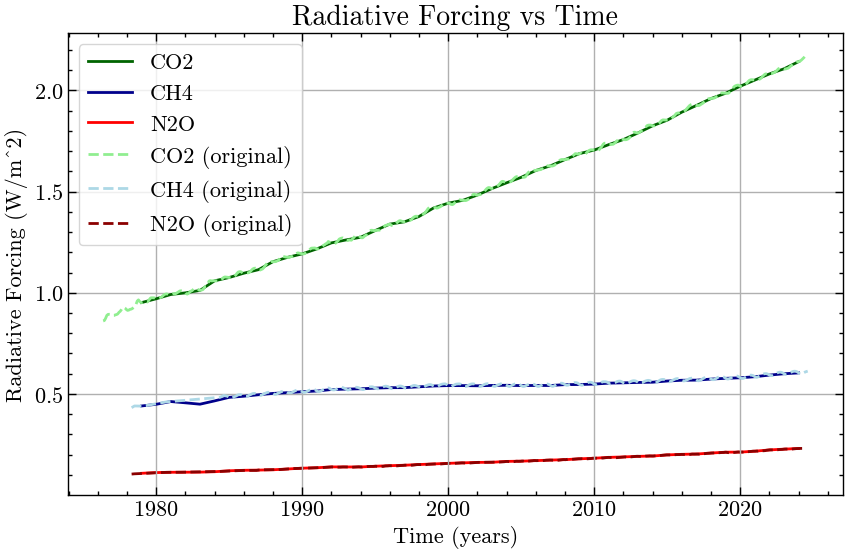

In [67]:
# Let's plot the interpolated data
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the interpolated data
ax.plot(time_interp, delta_F_CO2_interp, color = 'darkgreen', label = 'CO2', zorder = 3)
ax.plot(time_interp, delta_F_CH4_interp, color = 'darkblue', label = 'CH4', zorder = 2)
ax.plot(time_interp, delta_F_N2O_interp, color = 'red', label = 'N2O', zorder = 1)

# Plot the original data
ax.plot(time, delta_F_CO2, color = 'lightgreen', linestyle = '--', zorder = 3, label = 'CO2 (original)')
ax.plot(time_ch4, delta_F_CH4, color = 'lightblue', linestyle = '--', zorder = 2, label = 'CH4 (original)')
ax.plot(time_n2o, delta_F_N2O, color = 'darkred', linestyle = '--', zorder = 1, label = 'N2O (original)')


# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = 'Radiative Forcing (W/m^2)')
ax.set_title('Radiative Forcing vs Time', fontsize = 20)
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

We must point out that for CO2 we lose some data at the beginning since we decided to start the time array at 1979.

(e) Finally, use the interpolated data to calculate the **total radiative forcing** ($\Delta F_{\rm total}=\Delta F_{\text{CO}_2}+\Delta F_{\text{CH}_4}+\Delta F_{\text{N}_2\text{O}}$). Report the result in a high-quality, labeled plot of $\Delta F_{\rm global}$ (in $\rm W/m^2$) versus time in years.

In [68]:
# Now we can calculate the total radiative forcing by summing the radiative forcing of the three greenhouse gases
delta_F_total = delta_F_CO2_interp + delta_F_CH4_interp + delta_F_N2O_interp

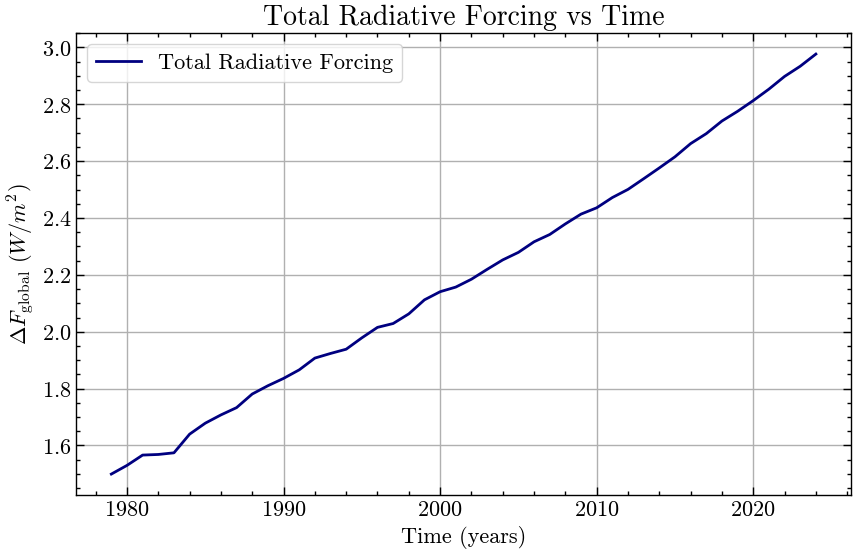

In [69]:
# Let's plot the total radiative forcing
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the total radiative forcing
ax.plot(time_interp, delta_F_total, color = 'navy', label = 'Total Radiative Forcing')

# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = r'$\Delta F_{\text{global}}$ $(W/m^2)$')
ax.set_title('Total Radiative Forcing vs Time', fontsize = 20)
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

## Problem 3. (6 points) Extrapolation: Global Warming

In this problem, you will study the correlation between the total radiative forcing ($\Delta F_{\rm total}$) and the sea temperature anomaly, which is an indicator of global warming. The sea temperature anomaly ($\Delta T_{\rm sea}$ in $\rm ^{\circ}C$) is measured with respect to the average global sea surface temperature (SST) in the 1961-1990 period ($=13.97\,\rm ^{\circ}C$). The observed data values are reported in this file:

https://github.com/wbandabarragan/physics-teaching-data/blob/main/1D-data/temperature-anomaly.csv

The file was taken from: https://ourworldindata.org

### Tasks:

(a) Create a python function that reads in the **temperature-anomaly.csv** file, selects the rows corresponding to the "Southern Hemisphere" anomaly, and returns the median temperature anomaly and symmetric $2\sigma$ y-errors computed from the upper and lower bounds given in the file. **Hint:** to calculate the symmetric $2\sigma$ y-errors, you can read the columns "Upper bound (95% CI)" and "Lower bound (95% CI)" and then average them.

In [72]:
# Let's read the temperature data
filename_temp = "./temperature-anomaly.csv"

# Read the data
def ReadTemperatureData(filename):
    """ 
    This function reads the temperature data file.

    Input:
    filename: the name of the file to read

    Output:
    time: the time data
    up_bound: the upper bound temperature data
    low_bound: the lower bound temperature data
    median_temp: the median temperature
    """
    # Read the data
    df = pd.read_csv(filename, sep = ',')
    # Get the temperature data corresponding to the Southern Hemisphere
    temp_data = df.loc[df["Entity"] == "Southern Hemisphere"]
    # Get the time data
    time = np.array(temp_data["Year"])
    # Get the temperature data
    up_bound = np.array(temp_data["Upper bound (95% CI)"])
    low_bound = np.array(temp_data["Lower bound (95% CI)"])
    median_temp = np.array(temp_data["Median temperature anomaly from 1961-1990 average"])

    return time, up_bound, low_bound, median_temp

In [73]:
# Call the function to read the temperature data
time_temp, up_bound_temp, low_bound_temp, median_temp = ReadTemperatureData(filename_temp)

In [74]:
# Calculate the error for the temperature anomaly
def TemperatureAnomalyError(up_bound, low_bound, median):
    """
    This function computes the symmetric 
    2-sigma error for the temperature anomaly
    
    Arguments:
            - up_bound (np.array)  : upper bound temperature data
            - low_bound (np.array) : lower bound temperature data
            - median (np.array)    : median temperature data

    Returns:
            - error (np.array) : error in the temperature data
    """
    
    # Compute d1 and d2
    d1 = abs(median - up_bound)
    d2 = abs(median - low_bound)
    
    # compute the errors
    error = (d1 + d2)/2
    
    return error

In [75]:
# Compute the error for the temperature anomaly
temp_err = TemperatureAnomalyError(up_bound_temp, low_bound_temp, median_temp)

(b) Make a high-quality, labeled figure of the sea temperature anomaly (in $\rm ^{\circ}C$) versus time (in years), including the symmetric $2\sigma$ y-errors for the temperature anomaly. What trend/s do you see? Briefly comment.

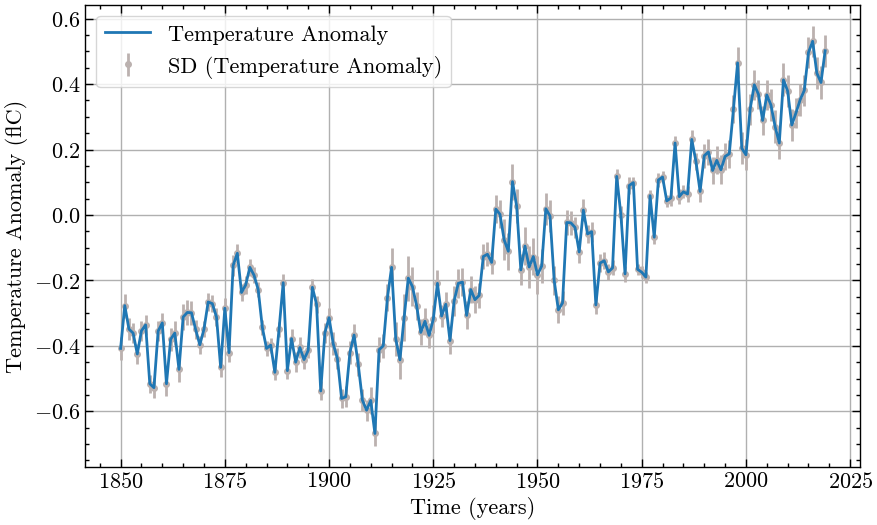

In [76]:
# Let's plot the temperature anomaly
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the temperature anomaly
ax.plot(time_temp, median_temp, color = '#1f77b4', label = 'Temperature Anomaly', zorder = 3)
ax.errorbar(time_temp, median_temp, yerr = temp_err, fmt = 'o', markersize = '4', color = '#bbb1af', label = 'SD (Temperature Anomaly)')
# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = 'Temperature Anomaly (°C)')
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

Having plotted the temperature anomaly data, we can see that the temperature anomaly is increasing with time. Nevertheless, the increasing trend seems not to be linear. We can see that after 1925 the temperature anomaly increases more rapidly than the period before 1925

(c) Since you want to study the correlation between the global radiative forcing ($\Delta F_{\rm total}$) from problem 2 and the sea temperature anomaly, both series need to cover the same time period in years. Use conditionals to select only the overlapping time periods, so that both data frames cover the same time ranges. Then, create and export (in CSV format) a new pandas data frame that contains 4 columns:

- Year

- Total radiative forcing ($\Delta F_{\rm total}$)

- Sea temperature anomaly 

- $2\sigma$ error in the sea temperature anommaly

In [77]:
# Since we want to compare the temperature anomaly with the total radiative forcing,
# we need to get the temperature anomaly data for the years 1979 to 2024

# Check the time range for the temperature anomaly
print(time_temp.min(), time_temp.max())
print(time_interp.min(), time_interp.max())

1850 2019
1979 2024


In [78]:
# Get the temperature anomaly data for the years 1979 to 2019
temp_data_new = median_temp[(time_temp >= 1979)]
temp_err_new = temp_err[(time_temp >= 1979)]
time_temp_new = time_temp[(time_temp >= 1979)]

In [79]:
# We also need to get the radiative forcing data until 2019 only
delta_F_total_new = delta_F_total[(time_interp <= 2019)]
time_interp_new = time_interp[(time_interp <= 2019)]

In [80]:
# Check the shape of the new temperature anomaly data
print(temp_data_new.shape)
print(temp_err_new.shape)
print(delta_F_total_new.shape)
print(time_interp_new.shape)

(41,)
(41,)
(41,)
(41,)


In [81]:
# Now that both the temperature anomaly and the total radiative forcing data are for the same time range,
# we can save the data in a csv file for further analysis
# Create a dictionary to store the data
new_df = {"Time (Years)": time_interp_new, "Total Radiative Forcing (W/m^2)": delta_F_total_new,
           "Sea Temperature Anomaly": temp_data_new, "Sea Temperature Anomaly Error": temp_err_new}

# Create a dataframe
df = pd.DataFrame(new_df)

# Save the data to a csv file
df.to_csv("./radiative_forcing_temperature_anomaly.csv", sep = ",")

(d) Make a labeled scatter plot (using markers) of the sea temperature anomaly (including the $2\sigma$ y-error bars) versus the total radiative forcing ($\Delta F_{\rm total}$. What trend/s do you see?

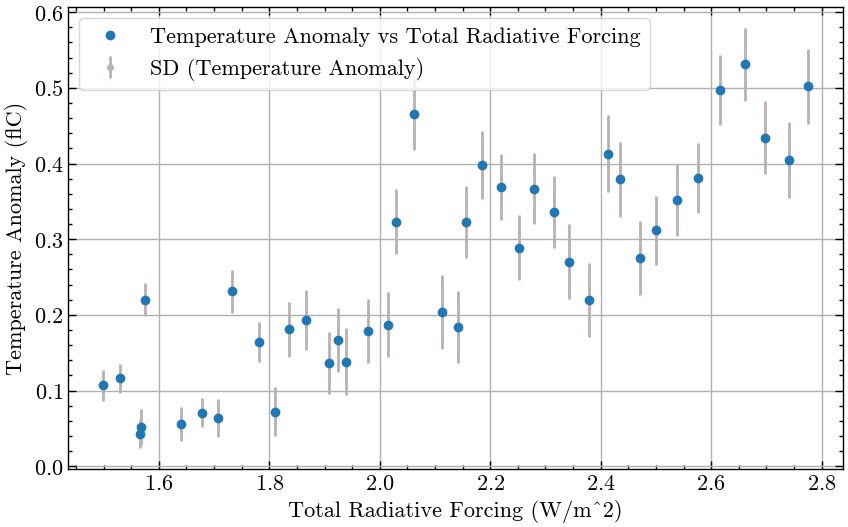

In [82]:
# Now let's plot the temperature anomaly vs the total radiative forcing
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the temperature anomaly
ax.plot(delta_F_total_new, temp_data_new, linestyle = '', marker = 'o', color = '#1f77b4',
         label = 'Temperature Anomaly vs Total Radiative Forcing', zorder = 3)
ax.errorbar(delta_F_total_new, temp_data_new, yerr = temp_err_new, fmt = 'o', markersize = '4',
             color = '#bbb1af', label = 'SD (Temperature Anomaly)')

# Add labels and title
ax.set(xlabel = 'Total Radiative Forcing (W/m^2)', ylabel = 'Temperature Anomaly (°C)')
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

Although the data points are a bit spread out, we can see that the overall trend is that the sea temperature anomaly increases with the total radiative forcing.

(e) Assume a linear model and carry out a regression. Report the resulting equation and figure showing the original data, the linear fit, and the literature prediction line: $\Delta T_{\rm sea}=k\,\Delta F_{\rm total}$, where $k=0.29\pm0.08\,\rm ^{\circ}C\,m^2/W$. How well does your regression result compare to the literature? Briefly discuss your results.

In [87]:
# Let's perform a linear regression. We will use the model_1 function defined earlier
# Define the chi^2 statistic function
def ChiSqrModel3(params):
    """
    Function to calculate the chi-square statistic for the linear model 1.

    Arguments:
            - params (np.array) : parameters of the model
    
    Returns:
            - chi_sqr (float) : chi-square statistic
    """
    # Extract the parameters
    m, b = params
    # Use the chi^2 formula
    chi_sqr = np.sum((temp_data_new - LinearModel1(delta_F_total_new, m, b))**2 / (temp_err_new)**2)
    
    return chi_sqr

In [88]:
# Perform the minimisation
# Ansatsz (educated guess)
coef_3 = np.array([0.5, 0.5])

# Call the minimisation routine
opt_model_3 = opt.minimize(ChiSqrModel3, coef_3)

# print the result
print(opt_model_3)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 166.37118168314274
        x: [ 3.089e-01 -3.941e-01]
      nit: 5
      jac: [ 1.907e-06  1.907e-06]
 hess_inv: [[ 1.067e-04 -1.996e-04]
            [-1.996e-04  3.872e-04]]
     nfev: 27
     njev: 9


In [89]:
# Extract the optimized parameters
m_opt, b_opt = opt_model_3.x

# Print the results
print("########## OPTIMAL PARAMETERS ###########")
print(f"Optimized m: {m_opt}")
print(f"Optimized b: {b_opt}")

print("########## UNCERTAINTIES ###########")
# Compute the uncertainties
m_err = np.sqrt(opt_model_3.hess_inv[0, 0])
b_err = np.sqrt(opt_model_3.hess_inv[1, 1])

print(f"Error in m: {m_err}")
print(f"Error in b: {b_err}")

########## OPTIMAL PARAMETERS ###########
Optimized m: 0.30893930854221746
Optimized b: -0.39412297756253645
########## UNCERTAINTIES ###########
Error in m: 0.010327446622067703
Error in b: 0.019678473395048204


In [90]:
# Define the linear model proposed by the literature
def LiteratureModel(forcing):
    """ 
    Literature model for the temperature anomaly vs the total radiative forcing.

    Arguments:
            - forcing (np.array) : total radiative forcing data

    Returns:
            - delta_temp_sea (np.array) : temperature anomaly data
    """
    k = 0.29 # +/- 0.08 °C/(W/m^2)
    delta_temp_sea = k * forcing

    return delta_temp_sea

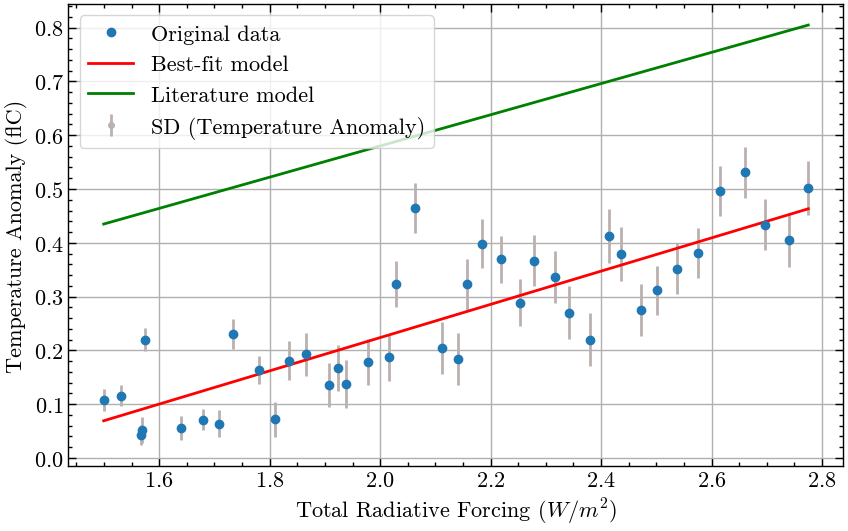

In [92]:
# Now we can plot the data, the literature model and the best-fit model
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the temperature anomaly
ax.plot(delta_F_total_new, temp_data_new, linestyle = '', marker = 'o', color = '#1f77b4',
         label = 'Original data', zorder = 3)
ax.errorbar(delta_F_total_new, temp_data_new, yerr = temp_err_new, fmt = 'o', markersize = '4',
             color = '#bbb1af', label = 'SD (Temperature Anomaly)')
# Plot the best-fit model
ax.plot(delta_F_total_new, LinearModel1(delta_F_total_new, m_opt, b_opt), color = 'red', linestyle = '-', label = 'Best-fit model')
# Plot the literature model
ax.plot(delta_F_total_new, LiteratureModel(delta_F_total_new), color = 'green', linestyle = '-', label = 'Literature model')

# Add labels and title
ax.set(xlabel = r'Total Radiative Forcing $(W/m^2)$', ylabel = 'Temperature Anomaly (°C)')
plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

If we compare out best-fitted model to the literature linear model, we can clearly see that the former is a better model to describe the data. This could happen because our model includes a extra parameter $b$, providing a better fit to the data. Nevertheless, if we compare the slope parameter $k$ of our model to the literature, we can see that they are in agreement within the uncertainties.

(f) Finally, you will make predictions for the future. Imagine the observed trends in greenhouse concentrations will continue in the next years. Use your regression model to predict $\Delta T_{\rm sea}$ in the years $2050$ and $2100$ via extrapolation. Report your results with uncertainties and show the expected trends in a figure. How much will the sea temperature have increased by those two years with respect to the reference SST?

In [93]:
# Define the chi^2 statistic function
def ChiSqrModel4(params):
    """
    Function to calculate the chi-square statistic for the linear model.

    Arguments:
            - params (np.array) : parameters of the model

    Returns:
            - chi_sqr (float) : chi-square statistic
    """
    # Extract the parameters
    a, b = params
    # Use the chi^2 formula
    chi_sqr = np.sum((median_temp - LinearModel1(time_temp, a, b))**2 / (temp_err)**2)
    
    return chi_sqr

In [94]:
# Perform the minimisation
coef_4 = np.array([0.001, -10])

# Call the minimisation routine
opt_model_4 = opt.minimize(ChiSqrModel4, coef_4)

# print the result
print(opt_model_4)

# Extract the optimized parameters
a_opt_4, b_opt_4 = opt_model_4.x

# Print the results
print("########## OPTIMAL PARAMETERS ###########")
print(f"Optimized a: {a_opt_4}")
print(f"Optimized b: {b_opt_4}")

print("########## UNCERTAINTIES ###########")
# Compute the uncertainties
a_err = np.sqrt(opt_model_4.hess_inv[0, 0])
b_err = np.sqrt(opt_model_4.hess_inv[1, 1])

print(f"Error in a: {a_err}")
print(f"Error in b: {b_err}")



  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3313.5735010668855
        x: [ 4.085e-03 -8.057e+00]
      nit: 2
      jac: [ 2.298e+02 -1.471e-02]
 hess_inv: [[ 1.240e-09 -2.396e-06]
            [-2.396e-06  4.633e-03]]
     nfev: 111
     njev: 33
########## OPTIMAL PARAMETERS ###########
Optimized a: 0.004085033671504352
Optimized b: -8.056963353266433
########## UNCERTAINTIES ###########
Error in a: 3.5217742528648734e-05
Error in b: 0.06806294702461946


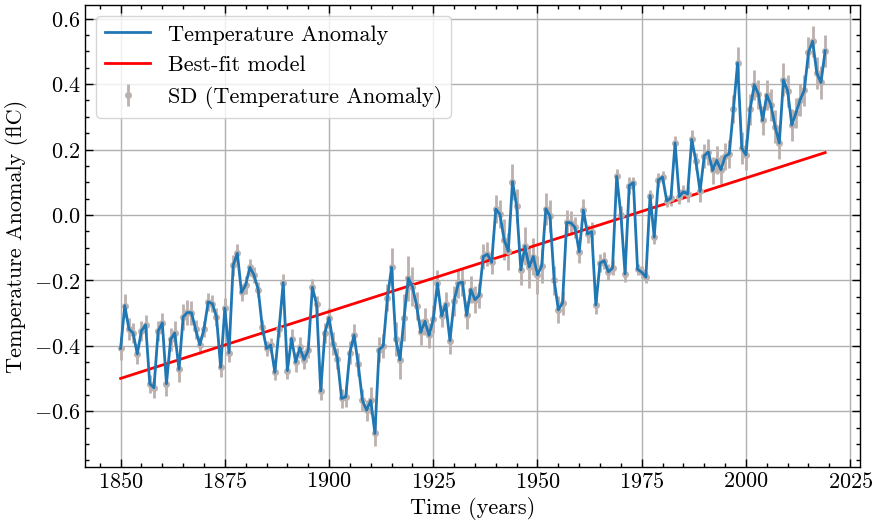

In [95]:
# Let's plot the temperature anomaly
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the temperature anomaly
ax.plot(time_temp, median_temp, color = '#1f77b4', label = 'Temperature Anomaly', zorder = 3)
ax.errorbar(time_temp, median_temp, yerr = temp_err, fmt = 'o', markersize = '4', color = '#bbb1af', label = 'SD (Temperature Anomaly)')
ax.plot(time_temp, LinearModel1(time_temp, a_opt_4, b_opt_4), color = 'red', linestyle = '-', label = 'Best-fit model')
# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = 'Temperature Anomaly (°C)')

plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

We can improve our model by splitting the data into two periods: before 1925 and after 1925. This way, we can model the second period with better accuracy.

In [96]:
# Split the data starting from 1920
split_time = time_temp[time_temp >= 1925]
split_temp = median_temp[time_temp >= 1925]
split_err = temp_err[time_temp >= 1925]

In [97]:
# Define the chi^2 statistic function
def ChiSqrModel5(params):
    """
    Function to calculate the chi-square statistic for the linear model.

    Arguments:
            - params (np.array) : parameters of the model

    Returns:
            - chi_sqr (float) : chi-square statistic
    """
    # Extract the parameters
    a, b = params
    # Use the chi^2 formula
    chi_sqr = np.sum((split_temp - LinearModel1(split_time, a, b))**2 / (split_err)**2)
    
    return chi_sqr

In [98]:
# Perform the minimisation
coef_5 = np.array([0.001, -10])

# Call the minimisation routine
opt_model_5 = opt.minimize(ChiSqrModel5, coef_5)

# print the result
print(opt_model_5)

# Extract the optimized parameters
a_opt_5, b_opt_5 = opt_model_5.x

# Print the results
print("########## OPTIMAL PARAMETERS ###########")
print(f"Optimized a: {a_opt_5}")
print(f"Optimized b: {b_opt_5}")

print("########## UNCERTAINTIES ###########")
# Compute the uncertainties
a_err_5 = np.sqrt(opt_model_5.hess_inv[0, 0])
b_err_5 = np.sqrt(opt_model_5.hess_inv[1, 1])

print(f"Error in a: {a_err_5}")
print(f"Error in b: {b_err_5}")

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1246.4898164466156
        x: [ 7.295e-03 -1.439e+01]
      nit: 2
      jac: [ 4.234e+01 -5.057e-01]
 hess_inv: [[ 1.286e-08 -2.538e-05]
            [-2.538e-05  5.008e-02]]
     nfev: 123
     njev: 37
########## OPTIMAL PARAMETERS ###########
Optimized a: 0.007294918338555525
Optimized b: -14.388259696731168
########## UNCERTAINTIES ###########
Error in a: 0.00011341409508535221
Error in b: 0.22377541688629024


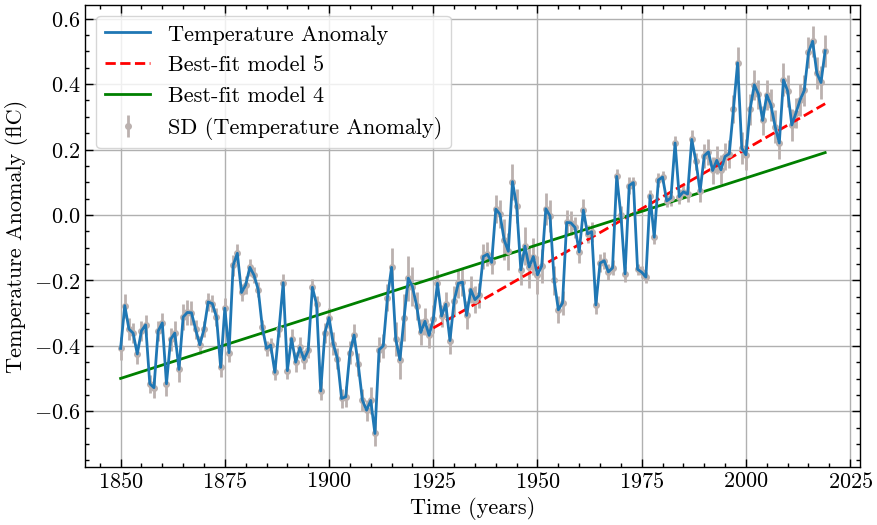

In [99]:
# Plot the temperature anomaly with the fit model 5
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the temperature anomaly
ax.plot(time_temp, median_temp, color = '#1f77b4', label = 'Temperature Anomaly', zorder = 3)
ax.errorbar(time_temp, median_temp, yerr = temp_err, fmt = 'o', markersize = '4', color = '#bbb1af', label = 'SD (Temperature Anomaly)')
ax.plot(split_time, LinearModel1(split_time, a_opt_5, b_opt_5), color = 'red', linestyle = '--', label = 'Best-fit model 5')
ax.plot(time_temp, LinearModel1(time_temp, a_opt_4, b_opt_4), color = 'green', linestyle = '-', label = 'Best-fit model 4')
# Add labels and title
ax.set(xlabel = 'Time (years)', ylabel = 'Temperature Anomaly (°C)')

plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

In [100]:
# Now, let's use the best-fit model to predict the temperature anomaly for the years 2050 and 2100

temp_2050 = LinearModel1(2050, a_opt_5, b_opt_5)
temp_2100 = LinearModel1(2100, a_opt_5, b_opt_5)

# Compute the error for the new temperature anomaly data
temp_err_2050 = np.sqrt((a_err_5 * 2050)**2)
temp_err_2100 = np.sqrt((a_err_5 * 2100)**2)

# Add the results to the temperature anomaly data
time_temp_2 = np.append(time_temp, [2050, 2100])
median_temp_2 = np.append(median_temp, [temp_2050, temp_2100])
temp_err_2 = np.append(temp_err, [temp_err_2050, temp_err_2100])



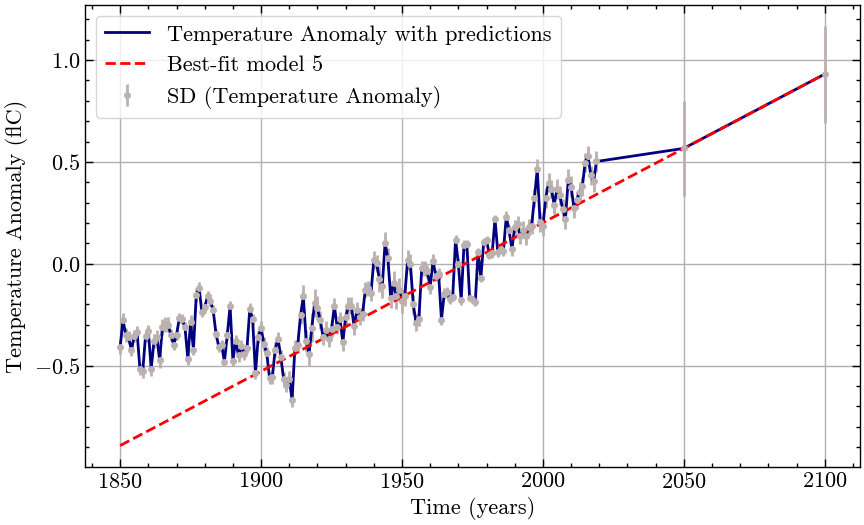

In [102]:
# Plot the temperature anomaly with the fit model 5
fig, ax = plt.subplots(figsize = (10, 6))

# Plot the temperature anomaly
#ax.plot(time_temp, median_temp, color = '#1f77b4', label = 'Temperature Anomaly', zorder = 3)
ax.errorbar(time_temp_2, median_temp_2, yerr = temp_err_2, fmt = 'o', markersize = '4', color = '#bbb1af', label = 'SD (Temperature Anomaly)',
            zorder = 2)
ax.plot(time_temp_2, median_temp_2, color = 'navy', linestyle = '-', label = 'Temperature Anomaly with predictions')
ax.plot(time_temp_2, LinearModel1(time_temp_2, a_opt_5, b_opt_5), color = 'red', linestyle = '--', label = 'Best-fit model 5')
# Add labels and title
plt.xlabel('Time (years)')
plt.ylabel('Temperature Anomaly (°C)')

plt.grid(True)
plt.legend(frameon = True)
plt.show()
plt.close()

In [103]:
# Print the temp at 2050 and 2100
print("Temperature anomaly at 2050: ", temp_2050)
print("Temperature anomaly at 2100: ", temp_2100)

Temperature anomaly at 2050:  0.5663228973076571
Temperature anomaly at 2100:  0.9310688142354344


Finally, by 2050, the sea temperature anomaly is expected to increase by $0.56 \rm ^{\circ}C$ with respect to the reference SST. By 2100, the sea temperature anomaly is expected to increase by $0.93\rm ^{\circ}C$ with respect to the reference SST.